In [484]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, naive_bayes, svm
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import seaborn as sns
import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [485]:
#carrega a base de treino
corpus_treino=pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/train.csv",encoding='latin-1')

# Resumo dos passos percorridos e conclusão
Neste tópico, iremos descrever de forma breve todos os testes desenvolvidos e a metodologia de trabalho. A cima de cada função, é possivel encontrar sua descrição e como as implementamos.

* Iniciamos nosso trabalho sumerisando os dados categoricos. Implementamos uma versão manual do label_encoder, uma para o one_hot_encoder e uma hibrida convertendo apenas categoricos com 4 ou menos campos.

* Nosso primeiro desafio foi "tapar" os buracos deixados pela falta de dados (objetos .nan). Tentamos diversas metodologias, por exemplo, inserir a média dos dados, maximos, minimos, constante 0 e por fim a utilização do algoritmos KNN como auxilio.

* Logo partimos para a compreenção dos dados, onde plotamos dois tipos de gráficos, o histograma e o gráfico boxplot. Eles foram extremamente uteis para a compreenção dos dados numéricos.

* Mesmo sem remover colunas ou adicionar novas features, fomos direto a implementação dos preditores, onde testamos diversos modelos. Percebemos que ao utilizar o label_encoder a precisão era em torno de 90% para o xgboost. 

* Nosso próximo desafio foi tentar detectar outliers, esta tarefa foi a mais dificil e de fato nós não conseguimos no sair bem nela. Identificamos diversos outliers e tentamos diversas abordagens como a remoção de linhas, colunas e etc. Mas todas causavam impacto negativo no nosso modelo. Foi então que resolvemos buscar um recurso da estatistica chamado boxplot, com ele nós conseguimos "remodelar" os dados de forma que ficassem dentro da box. Outra abordagem foi a transformação dos dados numéricos para log. A mistura dos dois recursos foi bastante benefica para algumas colunas e nos trouxe aproximadamente cerca de + 2% na precisão.

* Em seguida adicionamos uma função que remove uma coluna e verifica a precisão do modelo. Ela foi extremamente util para sabermos qual coluna não alterava os dados ou causava impacto negativo ao resultado final.

* Tentamos de diversas formas adicionar novas features relacionando colunas. E isto foi bastante promissor, conseguimos adicionar varias colunas que trouxeram um impacto positivo.

* Após diversas falhas e exitos fomos a uma implementação mais robusta do modelo escolhido, onde percorremos diversos parametros para ele e verificamos qual era mais benefico para nosso modelo final. 

* O score final foi de 93.35%, embora nos acreditemos que ainda seja possivel melhorar e muito esse score, estamos satisfeitos, pois conseguimos trabalhar com diversos recursos e técnicas de engenharia de atributos. Percebemos que é bastante desafiador encontrar novos dados atraves dos já existentes e principalmente detectar outliers, o que de fato nos deu muita dor de cabeça, mas não é algo impossivel.

* Resultado final: 

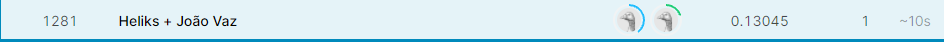

In [486]:
#train.sample(n=5)

# Label encoder
A função label_encoding transforma todos dados categoricos em inteiros (mais conhecido como label encoding ou integer encoding). Para o primeiro casos de teste, transformamos os dados NaN em 0. 

Todos os dados categóricos são convertidos para numeros inteiros, em primeiro momento, fizemos manualmente para nos aproximarmos dos dados e tentar compreendelos. No inicio pensamos que ela não seria mais eficaz que a distribuição one hot encoding, por isso, ao perceber sua eficacia, tentamos criar um hibrido entre as duas funções em diversos momentos da implementação.

In [487]:
#em primeiro momento essa função transforma todas string para um valor inteiro
def label_encoding(base):   
    #replace transforma todos os elementos vazios contidos no 
    #corpus para o valor 0
    #base.replace(np.nan, 0, inplace=True)
    
    base.loc[base.MSZoning=='A','MSZoning']=1
    base.loc[base.MSZoning=='C (all)','MSZoning']=2
    base.loc[base.MSZoning=='C','MSZoning']=2
    base.loc[base.MSZoning=='FV','MSZoning']=3
    base.loc[base.MSZoning=='I','MSZoning']=4
    base.loc[base.MSZoning=='RH','MSZoning']=5
    base.loc[base.MSZoning=='RL','MSZoning']=6
    base.loc[base.MSZoning=='RP','MSZoning']=7
    base.loc[base.MSZoning=='RM','MSZoning']=8
 #   base['MSZoning']=base['MSZoning'].astype(str).astype(int)
    
    base.loc[base.LotFrontage=='NA','LotFrontage']=0
    #base['LotFrontage']=base['LotFrontage'].astype(str).astype(int)
        
    base.loc[base.Street=='NA','Street']=0
    base.loc[base.Street=='Grvl','Street']=1
    base.loc[base.Street=='Pave','Street']=2
    base['Street']=base['Street'].astype(str).astype(int)

    base.loc[base.Alley== "NA",'Alley']=0
    base.loc[base.Alley=='Grvl','Alley']=1
    base.loc[base.Alley=='Pave','Alley']=2
    #base['Alley']=base['Alley'].astype(str).astype(int)

    base.loc[base.LotShape=='Reg','LotShape']=4
    base.loc[base.LotShape=='IR1','LotShape']=1
    base.loc[base.LotShape=='IR2','LotShape']=2
    base.loc[base.LotShape=='IR3','LotShape']=3
   # base['LotShape']=base['LotShape'].astype(str).astype(int)

    base.loc[base.LandContour=='Lvl','LandContour']=4
    base.loc[base.LandContour=='Bnk','LandContour']=1
    base.loc[base.LandContour=='HLS','LandContour']=2
    base.loc[base.LandContour=='Low','LandContour']=3
   # base['LandContour']=base['LandContour'].astype(str).astype(int)

    base.loc[base.Utilities=='AllPub','Utilities']=4
    base.loc[base.Utilities=='NoSewr','Utilities']=1
    base.loc[base.Utilities=='NoSeWa','Utilities']=2
    base.loc[base.Utilities=='ELO','Utilities']=3
   # base['Utilities']=base['Utilities'].astype(str).astype(int)

    base.loc[base.LotConfig=='Inside','LotConfig']=5
    base.loc[base.LotConfig=='Corner','LotConfig']=1
    base.loc[base.LotConfig=='CulDSac','LotConfig']=2
    base.loc[base.LotConfig=='FR2','LotConfig']=3
    base.loc[base.LotConfig=='FR3','LotConfig']=4
    #base['LotConfig']=base['LotConfig'].astype(str).astype(int)

    base.loc[base.LandSlope=='Gtl','LandSlope']=3
    base.loc[base.LandSlope=='Mod','LandSlope']=1
    base.loc[base.LandSlope=='Sev','LandSlope']=2
   # base['LandSlope']=base['LandSlope'].astype(str).astype(int)

    base.loc[base.Neighborhood=='Blmngtn','Neighborhood']=25
    base.loc[base.Neighborhood=='Blueste','Neighborhood']=1
    base.loc[base.Neighborhood=='BrDale','Neighborhood']=2
    base.loc[base.Neighborhood=='BrkSide','Neighborhood']=3
    base.loc[base.Neighborhood=='ClearCr','Neighborhood']=4
    base.loc[base.Neighborhood=='CollgCr','Neighborhood']=5
    base.loc[base.Neighborhood=='Crawfor','Neighborhood']=6
    base.loc[base.Neighborhood=='Edwards','Neighborhood']=7
    base.loc[base.Neighborhood=='Gilbert','Neighborhood']=8
    base.loc[base.Neighborhood=='IDOTRR','Neighborhood']=9
    base.loc[base.Neighborhood=='MeadowV','Neighborhood']=10
    base.loc[base.Neighborhood=='Mitchel','Neighborhood']=11
    base.loc[base.Neighborhood=='NAmes','Neighborhood']=12
    base.loc[base.Neighborhood=='NoRidge','Neighborhood']=13
    base.loc[base.Neighborhood=='NPkVill','Neighborhood']=14
    base.loc[base.Neighborhood=='NridgHt','Neighborhood']=15
    base.loc[base.Neighborhood=='NWAmes','Neighborhood']=16
    base.loc[base.Neighborhood=='OldTown','Neighborhood']=17
    base.loc[base.Neighborhood=='SWISU','Neighborhood']=18
    base.loc[base.Neighborhood=='Sawyer','Neighborhood']=19
    base.loc[base.Neighborhood=='SawyerW','Neighborhood']=20
    base.loc[base.Neighborhood=='Somerst','Neighborhood']=21
    base.loc[base.Neighborhood=='StoneBr','Neighborhood']=22
    base.loc[base.Neighborhood=='Timber','Neighborhood']=23
    base.loc[base.Neighborhood=='Veenker','Neighborhood']=24
    #base['Neighborhood']=base['Neighborhood'].astype(str).astype(int)

    base.loc[base.Condition1=='Artery','Condition1']=9
    base.loc[base.Condition1=='Feedr','Condition1']=1
    base.loc[base.Condition1=='Norm','Condition1']=2
    base.loc[base.Condition1=='RRNn','Condition1']=3
    base.loc[base.Condition1=='RRAn','Condition1']=4
    base.loc[base.Condition1=='PosN','Condition1']=5
    base.loc[base.Condition1=='PosA','Condition1']=6
    base.loc[base.Condition1=='RRNe','Condition1']=7
    base.loc[base.Condition1=='RRAe','Condition1']=8
   # base['Condition1']=base['Condition1'].astype(str).astype(int)

    base.loc[base.Condition2=='Artery','Condition2']=9
    base.loc[base.Condition2=='Feedr','Condition2']=1
    base.loc[base.Condition2=='Norm','Condition2']=2
    base.loc[base.Condition2=='RRNn','Condition2']=3
    base.loc[base.Condition2=='RRAn','Condition2']=4
    base.loc[base.Condition2=='PosN','Condition2']=5
    base.loc[base.Condition2=='PosA','Condition2']=6
    base.loc[base.Condition2=='RRNe','Condition2']=7
    base.loc[base.Condition2=='RRAe','Condition2']=8
   # base['Condition2']=base['Condition2'].astype(str).astype(int)

    #dar uma olhada no tipo TWNHS
    base.loc[base.BldgType=='1Fam','BldgType']=5
    base.loc[base.BldgType=='2fmCon','BldgType']=1
    base.loc[base.BldgType=='Duplex','BldgType']=2
    base.loc[base.BldgType=='TwnhsE','BldgType']=3
    base.loc[base.BldgType=='TwnhsI','BldgType']=4
    base.loc[base.BldgType=='Twnhs','BldgType']=4
  #  base['BldgType']=base['BldgType'].astype(str).astype(int)

    base.loc[base.HouseStyle=='1Story','HouseStyle']=8
    base.loc[base.HouseStyle=='1.5Fin','HouseStyle']=1
    base.loc[base.HouseStyle=='1.5Unf','HouseStyle']=2
    base.loc[base.HouseStyle=='2Story','HouseStyle']=3
    base.loc[base.HouseStyle=='2.5Fin','HouseStyle']=4
    base.loc[base.HouseStyle=='2.5Unf','HouseStyle']=5
    base.loc[base.HouseStyle=='SFoyer','HouseStyle']=6
    base.loc[base.HouseStyle=='SLvl','HouseStyle']=7
  #  base['HouseStyle']=base['HouseStyle'].astype(str).astype(int)

    base.loc[base.RoofStyle=='Flat','RoofStyle']=6
    base.loc[base.RoofStyle=='Gable','RoofStyle']=1
    base.loc[base.RoofStyle=='Gambrel','RoofStyle']=2
    base.loc[base.RoofStyle=='Hip','RoofStyle']=3
    base.loc[base.RoofStyle=='Mansard','RoofStyle']=4
    base.loc[base.RoofStyle=='Shed','RoofStyle']=5
   # base['RoofStyle']=base['RoofStyle'].astype(str).astype(int)

    base.loc[base.RoofMatl=='ClyTile','RoofMatl']=8
    base.loc[base.RoofMatl=='CompShg','RoofMatl']=1
    base.loc[base.RoofMatl=='Membran','RoofMatl']=2
    base.loc[base.RoofMatl=='Metal','RoofMatl']=3
    base.loc[base.RoofMatl=='Roll','RoofMatl']=4
    base.loc[base.RoofMatl=='Tar&Grv','RoofMatl']=5
    base.loc[base.RoofMatl=='WdShake','RoofMatl']=6
    base.loc[base.RoofMatl=='WdShngl','RoofMatl']=7
  #  base['RoofMatl']=base['RoofMatl'].astype(str).astype(int)

    #aqui também ocorrem bizarrises como Cemnt e cment
    base.loc[base.Exterior1st=='AsbShng','Exterior1st']=17
    base.loc[base.Exterior1st=='AsphShn','Exterior1st']=1
    base.loc[base.Exterior1st=='BrkComm','Exterior1st']=2
    base.loc[base.Exterior1st=='Brk Cmn','Exterior1st']=2
    base.loc[base.Exterior1st=='BrkFace','Exterior1st']=3
    base.loc[base.Exterior1st=='CBlock','Exterior1st']=4
    base.loc[base.Exterior1st=='CemntBd','Exterior1st']=5
    base.loc[base.Exterior1st=='CmentBd','Exterior1st']=5
    base.loc[base.Exterior1st=='HdBoard','Exterior1st']=6
    base.loc[base.Exterior1st=='ImStucc','Exterior1st']=7
    base.loc[base.Exterior1st=='MetalSd','Exterior1st']=8
    base.loc[base.Exterior1st=='Other','Exterior1st']=9
    base.loc[base.Exterior1st=='Plywood','Exterior1st']=10
    base.loc[base.Exterior1st=='PreCast','Exterior1st']=11
    base.loc[base.Exterior1st=='Stone','Exterior1st']=12
    base.loc[base.Exterior1st=='Stucco','Exterior1st']=13
    base.loc[base.Exterior1st=='VinylSd','Exterior1st']=14
    base.loc[base.Exterior1st=='Wd Sdng','Exterior1st']=15
    base.loc[base.Exterior1st=='WdShing','Exterior1st']=16
 #   base['Exterior1st']=base['Exterior1st'].astype(str).astype(int)

    base.loc[base.Exterior2nd=='AsbShng','Exterior2nd']=17
    base.loc[base.Exterior2nd=='AsphShn','Exterior2nd']=1
    base.loc[base.Exterior2nd=='BrkComm','Exterior2nd']=2
    base.loc[base.Exterior2nd=='Brk Cmn','Exterior2nd']=2
    base.loc[base.Exterior2nd=='BrkFace','Exterior2nd']=3
    base.loc[base.Exterior2nd=='CBlock','Exterior2nd']=4
    base.loc[base.Exterior2nd=='CemntBd','Exterior2nd']=5
    base.loc[base.Exterior2nd=='CmentBd','Exterior2nd']=5
    base.loc[base.Exterior2nd=='HdBoard','Exterior2nd']=6
    base.loc[base.Exterior2nd=='ImStucc','Exterior2nd']=7
    base.loc[base.Exterior2nd=='MetalSd','Exterior2nd']=8
    base.loc[base.Exterior2nd=='Other','Exterior2nd']=9
    base.loc[base.Exterior2nd=='Plywood','Exterior2nd']=10
    base.loc[base.Exterior2nd=='PreCast','Exterior2nd']=11
    base.loc[base.Exterior2nd=='Stone','Exterior2nd']=12
    base.loc[base.Exterior2nd=='Stucco','Exterior2nd']=13
    base.loc[base.Exterior2nd=='VinylSd','Exterior2nd']=14
    base.loc[base.Exterior2nd=='Wd Sdng','Exterior2nd']=15
    base.loc[base.Exterior2nd=='Wd Shng','Exterior2nd']=15
    base.loc[base.Exterior2nd=='WdShing','Exterior2nd']=16
  #  base['Exterior2nd']=base['Exterior2nd'].astype(str).astype(int)

    base.loc[base.MasVnrType=='BrkCmn','MasVnrType']=5
    base.loc[base.MasVnrType=='BrkFace','MasVnrType']=1
    base.loc[base.MasVnrType=='CBlock','MasVnrType']=2
    base.loc[base.MasVnrType=='None','MasVnrType']=3
    base.loc[base.MasVnrType=='Stone','MasVnrType']=4
   # base['MasVnrType']=base['MasVnrType'].astype(str).astype(int)

    base.loc[base.ExterQual=='Ex','ExterQual']=5
    base.loc[base.ExterQual=='Gd','ExterQual']=1
    base.loc[base.ExterQual=='TA','ExterQual']=2
    base.loc[base.ExterQual=='Fa','ExterQual']=3
    base.loc[base.ExterQual=='Po','ExterQual']=4
  #  base['ExterQual']=base['ExterQual'].astype(str).astype(int)

    base.loc[base.ExterCond=='Ex','ExterCond']=5
    base.loc[base.ExterCond=='Gd','ExterCond']=1
    base.loc[base.ExterCond=='TA','ExterCond']=2
    base.loc[base.ExterCond=='Fa','ExterCond']=3
    base.loc[base.ExterCond=='Po','ExterCond']=4
  #  base['ExterCond']=base['ExterCond'].astype(str).astype(int)

    base.loc[base.Foundation=='BrkTil','Foundation']=6
    base.loc[base.Foundation=='CBlock','Foundation']=1
    base.loc[base.Foundation=='PConc','Foundation']=2
    base.loc[base.Foundation=='Slab','Foundation']=3
    base.loc[base.Foundation=='Stone','Foundation']=4
    base.loc[base.Foundation=='Wood','Foundation']=5
 #   base['Foundation']=base['Foundation'].astype(str).astype(int)

    base.loc[base.BsmtQual=='Gd','BsmtQual']=1
    base.loc[base.BsmtQual=='TA','BsmtQual']=2
    base.loc[base.BsmtQual=='Fa','BsmtQual']=3
    base.loc[base.BsmtQual=='Po','BsmtQual']=4
    base.loc[base.BsmtQual=='Ex','BsmtQual']=5
  #  base['BsmtQual']=base['BsmtQual'].astype(str).astype(int)

    base.loc[base.BsmtCond=='Gd','BsmtCond']=1
    base.loc[base.BsmtCond=='TA','BsmtCond']=2
    base.loc[base.BsmtCond=='Fa','BsmtCond']=3
    base.loc[base.BsmtCond=='Po','BsmtCond']=4
    base.loc[base.BsmtCond=='Ex','BsmtCond']=5
 #   base['BsmtCond']=base['BsmtCond'].astype(str).astype(int)

    base.loc[base.BsmtExposure=='Av','BsmtExposure']=1
    base.loc[base.BsmtExposure=='Mn','BsmtExposure']=2
    base.loc[base.BsmtExposure=='No','BsmtExposure']=3
    base.loc[base.BsmtExposure=='Gd','BsmtExposure']=4
  #  base['BsmtExposure']=base['BsmtExposure'].astype(str).astype(int)

    base.loc[base.BsmtFinType1=='GLQ','BsmtFinType1']=6
    base.loc[base.BsmtFinType1=='ALQ','BsmtFinType1']=1
    base.loc[base.BsmtFinType1=='BLQ','BsmtFinType1']=2
    base.loc[base.BsmtFinType1=='Rec','BsmtFinType1']=3
    base.loc[base.BsmtFinType1=='LwQ','BsmtFinType1']=4
    base.loc[base.BsmtFinType1=='Unf','BsmtFinType1']=5
  #  base['BsmtFinType1']=base['BsmtFinType1'].astype(str).astype(int)

    base.loc[base.BsmtFinType2=='GLQ','BsmtFinType2']=6
    base.loc[base.BsmtFinType2=='ALQ','BsmtFinType2']=1
    base.loc[base.BsmtFinType2=='BLQ','BsmtFinType2']=2
    base.loc[base.BsmtFinType2=='Rec','BsmtFinType2']=3
    base.loc[base.BsmtFinType2=='LwQ','BsmtFinType2']=4
    base.loc[base.BsmtFinType2=='Unf','BsmtFinType2']=5
 #   base['BsmtFinType2']=base['BsmtFinType2'].astype(str).astype(int)

    base.loc[base.Heating=='Floor','Heating']=6
    base.loc[base.Heating=='GasA','Heating']=1
    base.loc[base.Heating=='GasW','Heating']=2
    base.loc[base.Heating=='Grav','Heating']=3
    base.loc[base.Heating=='OthW','Heating']=4
    base.loc[base.Heating=='Wall','Heating']=5
 #   base['Heating']=base['Heating'].astype(str).astype(int)

    base.loc[base.HeatingQC=='Ex','HeatingQC']=5
    base.loc[base.HeatingQC=='Gd','HeatingQC']=1
    base.loc[base.HeatingQC=='TA','HeatingQC']=2
    base.loc[base.HeatingQC=='Fa','HeatingQC']=3
    base.loc[base.HeatingQC=='Po','HeatingQC']=4
  #  base['HeatingQC']=base['HeatingQC'].astype(str).astype(int)

    base.loc[base.CentralAir=='N','CentralAir']=2
    base.loc[base.CentralAir=='Y','CentralAir']=1
   # base['CentralAir']=base['CentralAir'].astype(str).astype(int)

    base.loc[base.Electrical=='SBrkr','Electrical']=5
    base.loc[base.Electrical=='FuseA','Electrical']=1
    base.loc[base.Electrical=='FuseF','Electrical']=2
    base.loc[base.Electrical=='FuseP','Electrical']=3
    base.loc[base.Electrical=='Mix','Electrical']=4
  #  base['Electrical']=base['Electrical'].astype(str).astype(int)

    base.loc[base.KitchenQual=='Ex','KitchenQual']=5
    base.loc[base.KitchenQual=='Gd','KitchenQual']=1
    base.loc[base.KitchenQual=='TA','KitchenQual']=2
    base.loc[base.KitchenQual=='Fa','KitchenQual']=3
    base.loc[base.KitchenQual=='Po','KitchenQual']=4
   # base['KitchenQual']=base['KitchenQual'].astype(str).astype(int)

    base.loc[base.Functional=='Typ','Functional']=8
    base.loc[base.Functional=='Min1','Functional']=1
    base.loc[base.Functional=='Min2','Functional']=2
    base.loc[base.Functional=='Mod','Functional']=3
    base.loc[base.Functional=='Maj1','Functional']=4
    base.loc[base.Functional=='Maj2','Functional']=5
    base.loc[base.Functional=='Sev','Functional']=6
    base.loc[base.Functional=='Sal','Functional']=7
  #  base['Functional']=base['Functional'].astype(str).astype(int)


    base.loc[base.FireplaceQu=='Ex','FireplaceQu']=6
    base.loc[base.FireplaceQu=='Gd','FireplaceQu']=1
    base.loc[base.FireplaceQu=='TA','FireplaceQu']=2
    base.loc[base.FireplaceQu=='Fa','FireplaceQu']=3
    base.loc[base.FireplaceQu=='Po','FireplaceQu']=4
    base.loc[base.FireplaceQu=='NA','FireplaceQu']=5
  #  base['FireplaceQu']=base['FireplaceQu'].astype(str).astype(int)

    base.loc[base.GarageType=='2Types','GarageType']=6
    base.loc[base.GarageType=='Attchd','GarageType']=1
    base.loc[base.GarageType=='Basment','GarageType']=2
    base.loc[base.GarageType=='BuiltIn','GarageType']=3
    base.loc[base.GarageType=='CarPort','GarageType']=4
    base.loc[base.GarageType=='Detchd','GarageType']=5
  #  base['GarageType']=base['GarageType'].astype(str).astype(int)
    
    base.loc[base.GarageFinish=='Fin','GarageFinish']=3
    base.loc[base.GarageFinish=='RFn','GarageFinish']=1
    base.loc[base.GarageFinish=='Unf','GarageFinish']=2
   # base['GarageFinish']=base['GarageFinish'].astype(str).astype(int)

    base.loc[base.GarageQual=='Ex','GarageQual']=5
    base.loc[base.GarageQual=='Gd','GarageQual']=1
    base.loc[base.GarageQual=='TA','GarageQual']=2
    base.loc[base.GarageQual=='Fa','GarageQual']=3
    base.loc[base.GarageQual=='Po','GarageQual']=4
  #  base['GarageQual']=base['GarageQual'].astype(str).astype(int)

    base.loc[base.GarageCond=='Ex','GarageCond']=5
    base.loc[base.GarageCond=='Gd','GarageCond']=1
    base.loc[base.GarageCond=='TA','GarageCond']=2
    base.loc[base.GarageCond=='Fa','GarageCond']=3
    base.loc[base.GarageCond=='Po','GarageCond']=4
  #  base['GarageCond']=base['GarageCond'].astype(str).astype(int)

    base.loc[base.PavedDrive=='Y','PavedDrive']=3
    base.loc[base.PavedDrive=='P','PavedDrive']=1
    base.loc[base.PavedDrive=='N','PavedDrive']=2
  #  base['PavedDrive']=base['PavedDrive'].astype(str).astype(int)
#
    base.loc[base.PoolQC=='Ex','PoolQC']=5
    base.loc[base.PoolQC=='Gd','PoolQC']=1
    base.loc[base.PoolQC=='TA','PoolQC']=2
    base.loc[base.PoolQC=='Fa','PoolQC']=3
    base.loc[base.PoolQC=='Po','PoolQC']=4
  #  base['PoolQC']=base['PoolQC'].astype(str).astype(int)

    base.loc[base.Fence=='GdPrv','Fence']=4
    base.loc[base.Fence=='MnPrv','Fence']=1
    base.loc[base.Fence=='GdWo','Fence']=2
    base.loc[base.Fence=='MnWw','Fence']=3
  #  base['Fence']=base['Fence'].astype(str).astype(int)

    base.loc[base.MiscFeature=='Elev','MiscFeature']=5
    base.loc[base.MiscFeature=='Gar2','MiscFeature']=1
    base.loc[base.MiscFeature=='Gar2','MiscFeature']=2
    base.loc[base.MiscFeature=='Shed','MiscFeature']=3
    base.loc[base.MiscFeature=='TenC','MiscFeature']=4
    base.loc[base.MiscFeature=='Othr','MiscFeature']=6
  #  base['MiscFeature']=base['MiscFeature'].astype(str).astype(int)

    base.loc[base.SaleType=='WD','SaleType']=10
    base.loc[base.SaleType=='CWD','SaleType']=1
    base.loc[base.SaleType=='VWD','SaleType']=2
    base.loc[base.SaleType=='New','SaleType']=3
    base.loc[base.SaleType=='COD','SaleType']=4
    base.loc[base.SaleType=='Con','SaleType']=5
    base.loc[base.SaleType=='ConLw','SaleType']=6
    base.loc[base.SaleType=='ConLI','SaleType']=7
    base.loc[base.SaleType=='ConLD','SaleType']=8
    base.loc[base.SaleType=='Oth','SaleType']=9
  #  base['SaleType']=base['SaleType'].astype(str).astype(int)

    base.loc[base.SaleCondition=='Normal','SaleCondition']=6
    base.loc[base.SaleCondition=='Abnorml','SaleCondition']=1
    base.loc[base.SaleCondition=='AdjLand','SaleCondition']=2
    base.loc[base.SaleCondition=='Alloca','SaleCondition']=3
    base.loc[base.SaleCondition=='Family','SaleCondition']=4
    base.loc[base.SaleCondition=='Partial','SaleCondition']=5
   # base['SaleCondition']=base['SaleCondition'].astype(str).astype(int)
    
    return base

# One Hot Encoder

Simplismente tranforma os dados categóricos em 0's e 1's, criando novas colunas para alocar os dados. vale mencionar que o uso dele não foi muito promissor para os nossos testes.

In [488]:
#em primeiro momento essa função transforma todas string para um valor inteiro
def one_hot_encoding(df):   
    #valores categoricos faltantes foram convertidos em MISS
    #valores numericos faltantes foram convertidos em 0
    df.MSZoning.fillna('Miss',inplace=True)
    df.LotFrontage.fillna(0,inplace=True)
    df.Alley.fillna('Miss',inplace=True)
    df.MasVnrType.fillna('Miss',inplace=True)
    df.MasVnrArea.fillna(0,inplace=True)
    df.BsmtQual.fillna('Miss',inplace=True)
    df.BsmtCond.fillna('Miss',inplace=True)
    df.BsmtExposure.fillna('Miss',inplace=True)
    df.BsmtFinType1.fillna('Miss',inplace=True)
    df.BsmtFinType2.fillna('Miss',inplace=True)
    df.Electrical.fillna('Miss',inplace=True)
    df.FireplaceQu.fillna('Miss',inplace=True)
    df.GarageType.fillna('Miss',inplace=True)
    df.GarageYrBlt.fillna(0,inplace=True)
    df.GarageFinish.fillna('Miss',inplace=True)
    df.PoolQC.fillna('Miss',inplace=True)
    df.Fence.fillna('Miss',inplace=True)
    df.MiscFeature.fillna('Miss',inplace=True) 
    
    
    df.SaleType.fillna('WD',inplace=True)  
    df.GarageCars.fillna(0,inplace=True)  
    df.GarageArea.fillna(0,inplace=True)  
    df.KitchenQual.fillna('TA',inplace=True)  ##
    df.Functional.fillna('Typ',inplace=True) 
    df.BsmtFullBath.fillna(0,inplace=True)  
    df.BsmtHalfBath.fillna(0,inplace=True) 
    
    df_ohe = pd.concat([df[['MSSubClass','LotFrontage','LotArea','OverallQual',
                           'OverallCond','YearBuilt','YearRemodAdd','MasVnrArea',
                          'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                          '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath',
                          'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                           'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea',
                          'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                          'PoolArea','MiscVal','MoSold','YrSold']],
                       pd.get_dummies(df[['MSZoning','Street','Alley','LandSlope',
                                        'LotShape','LandContour','Utilities','LotConfig',
                                         'Neighborhood','Condition1','Condition2','BldgType',
                                         'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                                         'Exterior2nd','MasVnrType','ExterQual','ExterCond',
                                         'Foundation','BsmtQual','BsmtCond','BsmtExposure',
                                         'BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC',
                                         'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
                                         'FireplaceQu', 'GarageType', 'GarageFinish','GarageQual',
                                         'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
                                         'SaleType','SaleCondition']],drop_first=True)],axis=1)
    
    
    return df_ohe

# Encoder hibrido

Simplismente transforma dados categóricos contendo até 4 tipos em one_hot_encoding e o restante para label_encoder. O seu uso foi mais eficas que a abordagem one_hot_encoding, embora não tão boa quanto o label_encoder.

In [489]:
def encoding_hybrid(base):   
    #replace transforma todos os elementos vazios contidos no 
    #corpus para o valor 0
    base.replace(np.nan, 0, inplace=True)
    
    base.loc[base.MSZoning=='A','MSZoning']=1
    base.loc[base.MSZoning=='C (all)','MSZoning']=2
    base.loc[base.MSZoning=='C','MSZoning']=2
    base.loc[base.MSZoning=='FV','MSZoning']=3
    base.loc[base.MSZoning=='I','MSZoning']=4
    base.loc[base.MSZoning=='RH','MSZoning']=5
    base.loc[base.MSZoning=='RL','MSZoning']=6
    base.loc[base.MSZoning=='RP','MSZoning']=7
    base.loc[base.MSZoning=='RM','MSZoning']=8
    base['MSZoning']=base['MSZoning'].astype(str).astype(int)
    
    base.loc[base.LotFrontage=='NA','LotFrontage']=0
    #base['LotFrontage']=base['LotFrontage'].astype(str).astype(int)
        
    #base.loc[base.Street=='NA','Street']=0
   # base.loc[base.Street=='Grvl','Street']=1
   # base.loc[base.Street=='Pave','Street']=2
   # base['Street']=base['Street'].astype(str).astype(int)

   # base.loc[base.Alley== "NA",'Alley']=0
   # base.loc[base.Alley=='Grvl','Alley']=1
   # base.loc[base.Alley=='Pave','Alley']=2
   # base['Alley']=base['Alley'].astype(str).astype(int)

   # base.loc[base.LotShape=='Reg','LotShape']=4
  #  base.loc[base.LotShape=='IR1','LotShape']=1
   # base.loc[base.LotShape=='IR2','LotShape']=2
   # base.loc[base.LotShape=='IR3','LotShape']=3
    #base['LotShape']=base['LotShape'].astype(str).astype(int)

  #  base.loc[base.LandContour=='Lvl','LandContour']=4
  #  base.loc[base.LandContour=='Bnk','LandContour']=1
  #  base.loc[base.LandContour=='HLS','LandContour']=2
  #  base.loc[base.LandContour=='Low','LandContour']=3
  #  base['LandContour']=base['LandContour'].astype(str).astype(int)

  #  base.loc[base.Utilities=='AllPub','Utilities']=4
  #  base.loc[base.Utilities=='NoSewr','Utilities']=1
  #  base.loc[base.Utilities=='NoSeWa','Utilities']=2
  #  base.loc[base.Utilities=='ELO','Utilities']=3
  #  base['Utilities']=base['Utilities'].astype(str).astype(int)

    base.loc[base.LotConfig=='Inside','LotConfig']=5
    base.loc[base.LotConfig=='Corner','LotConfig']=1
    base.loc[base.LotConfig=='CulDSac','LotConfig']=2
    base.loc[base.LotConfig=='FR2','LotConfig']=3
    base.loc[base.LotConfig=='FR3','LotConfig']=4
    base['LotConfig']=base['LotConfig'].astype(str).astype(int)

  #  base.loc[base.LandSlope=='Gtl','LandSlope']=3
  #  base.loc[base.LandSlope=='Mod','LandSlope']=1
  #  base.loc[base.LandSlope=='Sev','LandSlope']=2
  #  base['LandSlope']=base['LandSlope'].astype(str).astype(int)

    base.loc[base.Neighborhood=='Blmngtn','Neighborhood']=25
    base.loc[base.Neighborhood=='Blueste','Neighborhood']=1
    base.loc[base.Neighborhood=='BrDale','Neighborhood']=2
    base.loc[base.Neighborhood=='BrkSide','Neighborhood']=3
    base.loc[base.Neighborhood=='ClearCr','Neighborhood']=4
    base.loc[base.Neighborhood=='CollgCr','Neighborhood']=5
    base.loc[base.Neighborhood=='Crawfor','Neighborhood']=6
    base.loc[base.Neighborhood=='Edwards','Neighborhood']=7
    base.loc[base.Neighborhood=='Gilbert','Neighborhood']=8
    base.loc[base.Neighborhood=='IDOTRR','Neighborhood']=9
    base.loc[base.Neighborhood=='MeadowV','Neighborhood']=10
    base.loc[base.Neighborhood=='Mitchel','Neighborhood']=11
    base.loc[base.Neighborhood=='NAmes','Neighborhood']=12
    base.loc[base.Neighborhood=='NoRidge','Neighborhood']=13
    base.loc[base.Neighborhood=='NPkVill','Neighborhood']=14
    base.loc[base.Neighborhood=='NridgHt','Neighborhood']=15
    base.loc[base.Neighborhood=='NWAmes','Neighborhood']=16
    base.loc[base.Neighborhood=='OldTown','Neighborhood']=17
    base.loc[base.Neighborhood=='SWISU','Neighborhood']=18
    base.loc[base.Neighborhood=='Sawyer','Neighborhood']=19
    base.loc[base.Neighborhood=='SawyerW','Neighborhood']=20
    base.loc[base.Neighborhood=='Somerst','Neighborhood']=21
    base.loc[base.Neighborhood=='StoneBr','Neighborhood']=22
    base.loc[base.Neighborhood=='Timber','Neighborhood']=23
    base.loc[base.Neighborhood=='Veenker','Neighborhood']=24
    base['Neighborhood']=base['Neighborhood'].astype(str).astype(int)

    base.loc[base.Condition1=='Artery','Condition1']=9
    base.loc[base.Condition1=='Feedr','Condition1']=1
    base.loc[base.Condition1=='Norm','Condition1']=2
    base.loc[base.Condition1=='RRNn','Condition1']=3
    base.loc[base.Condition1=='RRAn','Condition1']=4
    base.loc[base.Condition1=='PosN','Condition1']=5
    base.loc[base.Condition1=='PosA','Condition1']=6
    base.loc[base.Condition1=='RRNe','Condition1']=7
    base.loc[base.Condition1=='RRAe','Condition1']=8
    base['Condition1']=base['Condition1'].astype(str).astype(int)

    base.loc[base.Condition2=='Artery','Condition2']=9
    base.loc[base.Condition2=='Feedr','Condition2']=1
    base.loc[base.Condition2=='Norm','Condition2']=2
    base.loc[base.Condition2=='RRNn','Condition2']=3
    base.loc[base.Condition2=='RRAn','Condition2']=4
    base.loc[base.Condition2=='PosN','Condition2']=5
    base.loc[base.Condition2=='PosA','Condition2']=6
    base.loc[base.Condition2=='RRNe','Condition2']=7
    base.loc[base.Condition2=='RRAe','Condition2']=8
    base['Condition2']=base['Condition2'].astype(str).astype(int)

    #dar uma olhada no tipo TWNHS
    base.loc[base.BldgType=='1Fam','BldgType']=5
    base.loc[base.BldgType=='2fmCon','BldgType']=1
    base.loc[base.BldgType=='Duplex','BldgType']=2
    base.loc[base.BldgType=='TwnhsE','BldgType']=3
    base.loc[base.BldgType=='TwnhsI','BldgType']=4
    base.loc[base.BldgType=='Twnhs','BldgType']=4
    base['BldgType']=base['BldgType'].astype(str).astype(int)

    base.loc[base.HouseStyle=='1Story','HouseStyle']=8
    base.loc[base.HouseStyle=='1.5Fin','HouseStyle']=1
    base.loc[base.HouseStyle=='1.5Unf','HouseStyle']=2
    base.loc[base.HouseStyle=='2Story','HouseStyle']=3
    base.loc[base.HouseStyle=='2.5Fin','HouseStyle']=4
    base.loc[base.HouseStyle=='2.5Unf','HouseStyle']=5
    base.loc[base.HouseStyle=='SFoyer','HouseStyle']=6
    base.loc[base.HouseStyle=='SLvl','HouseStyle']=7
    base['HouseStyle']=base['HouseStyle'].astype(str).astype(int)

    base.loc[base.RoofStyle=='Flat','RoofStyle']=6
    base.loc[base.RoofStyle=='Gable','RoofStyle']=1
    base.loc[base.RoofStyle=='Gambrel','RoofStyle']=2
    base.loc[base.RoofStyle=='Hip','RoofStyle']=3
    base.loc[base.RoofStyle=='Mansard','RoofStyle']=4
    base.loc[base.RoofStyle=='Shed','RoofStyle']=5
    base['RoofStyle']=base['RoofStyle'].astype(str).astype(int)

    base.loc[base.RoofMatl=='ClyTile','RoofMatl']=8
    base.loc[base.RoofMatl=='CompShg','RoofMatl']=1
    base.loc[base.RoofMatl=='Membran','RoofMatl']=2
    base.loc[base.RoofMatl=='Metal','RoofMatl']=3
    base.loc[base.RoofMatl=='Roll','RoofMatl']=4
    base.loc[base.RoofMatl=='Tar&Grv','RoofMatl']=5
    base.loc[base.RoofMatl=='WdShake','RoofMatl']=6
    base.loc[base.RoofMatl=='WdShngl','RoofMatl']=7
    base['RoofMatl']=base['RoofMatl'].astype(str).astype(int)

    #aqui também ocorrem bizarrises como Cemnt e cment
    base.loc[base.Exterior1st=='AsbShng','Exterior1st']=17
    base.loc[base.Exterior1st=='AsphShn','Exterior1st']=1
    base.loc[base.Exterior1st=='BrkComm','Exterior1st']=2
    base.loc[base.Exterior1st=='Brk Cmn','Exterior1st']=2
    base.loc[base.Exterior1st=='BrkFace','Exterior1st']=3
    base.loc[base.Exterior1st=='CBlock','Exterior1st']=4
    base.loc[base.Exterior1st=='CemntBd','Exterior1st']=5
    base.loc[base.Exterior1st=='CmentBd','Exterior1st']=5
    base.loc[base.Exterior1st=='HdBoard','Exterior1st']=6
    base.loc[base.Exterior1st=='ImStucc','Exterior1st']=7
    base.loc[base.Exterior1st=='MetalSd','Exterior1st']=8
    base.loc[base.Exterior1st=='Other','Exterior1st']=9
    base.loc[base.Exterior1st=='Plywood','Exterior1st']=10
    base.loc[base.Exterior1st=='PreCast','Exterior1st']=11
    base.loc[base.Exterior1st=='Stone','Exterior1st']=12
    base.loc[base.Exterior1st=='Stucco','Exterior1st']=13
    base.loc[base.Exterior1st=='VinylSd','Exterior1st']=14
    base.loc[base.Exterior1st=='Wd Sdng','Exterior1st']=15
    base.loc[base.Exterior1st=='WdShing','Exterior1st']=16
    base['Exterior1st']=base['Exterior1st'].astype(str).astype(int)

    base.loc[base.Exterior2nd=='AsbShng','Exterior2nd']=17
    base.loc[base.Exterior2nd=='AsphShn','Exterior2nd']=1
    base.loc[base.Exterior2nd=='BrkComm','Exterior2nd']=2
    base.loc[base.Exterior2nd=='Brk Cmn','Exterior2nd']=2
    base.loc[base.Exterior2nd=='BrkFace','Exterior2nd']=3
    base.loc[base.Exterior2nd=='CBlock','Exterior2nd']=4
    base.loc[base.Exterior2nd=='CemntBd','Exterior2nd']=5
    base.loc[base.Exterior2nd=='CmentBd','Exterior2nd']=5
    base.loc[base.Exterior2nd=='HdBoard','Exterior2nd']=6
    base.loc[base.Exterior2nd=='ImStucc','Exterior2nd']=7
    base.loc[base.Exterior2nd=='MetalSd','Exterior2nd']=8
    base.loc[base.Exterior2nd=='Other','Exterior2nd']=9
    base.loc[base.Exterior2nd=='Plywood','Exterior2nd']=10
    base.loc[base.Exterior2nd=='PreCast','Exterior2nd']=11
    base.loc[base.Exterior2nd=='Stone','Exterior2nd']=12
    base.loc[base.Exterior2nd=='Stucco','Exterior2nd']=13
    base.loc[base.Exterior2nd=='VinylSd','Exterior2nd']=14
    base.loc[base.Exterior2nd=='Wd Sdng','Exterior2nd']=15
    base.loc[base.Exterior2nd=='Wd Shng','Exterior2nd']=15
    base.loc[base.Exterior2nd=='WdShing','Exterior2nd']=16
    base['Exterior2nd']=base['Exterior2nd'].astype(str).astype(int)

    base.loc[base.MasVnrType=='BrkCmn','MasVnrType']=5
    base.loc[base.MasVnrType=='BrkFace','MasVnrType']=1
    base.loc[base.MasVnrType=='CBlock','MasVnrType']=2
    base.loc[base.MasVnrType=='None','MasVnrType']=3
    base.loc[base.MasVnrType=='Stone','MasVnrType']=4
    base['MasVnrType']=base['MasVnrType'].astype(str).astype(int)

    base.loc[base.ExterQual=='Ex','ExterQual']=5
    base.loc[base.ExterQual=='Gd','ExterQual']=1
    base.loc[base.ExterQual=='TA','ExterQual']=2
    base.loc[base.ExterQual=='Fa','ExterQual']=3
    base.loc[base.ExterQual=='Po','ExterQual']=4
    base['ExterQual']=base['ExterQual'].astype(str).astype(int)

    base.loc[base.ExterCond=='Ex','ExterCond']=5
    base.loc[base.ExterCond=='Gd','ExterCond']=1
    base.loc[base.ExterCond=='TA','ExterCond']=2
    base.loc[base.ExterCond=='Fa','ExterCond']=3
    base.loc[base.ExterCond=='Po','ExterCond']=4
    base['ExterCond']=base['ExterCond'].astype(str).astype(int)

    base.loc[base.Foundation=='BrkTil','Foundation']=6
    base.loc[base.Foundation=='CBlock','Foundation']=1
    base.loc[base.Foundation=='PConc','Foundation']=2
    base.loc[base.Foundation=='Slab','Foundation']=3
    base.loc[base.Foundation=='Stone','Foundation']=4
    base.loc[base.Foundation=='Wood','Foundation']=5
    base['Foundation']=base['Foundation'].astype(str).astype(int)

    base.loc[base.BsmtQual=='Gd','BsmtQual']=1
    base.loc[base.BsmtQual=='TA','BsmtQual']=2
    base.loc[base.BsmtQual=='Fa','BsmtQual']=3
    base.loc[base.BsmtQual=='Po','BsmtQual']=4
    base.loc[base.BsmtQual=='Ex','BsmtQual']=5
    base['BsmtQual']=base['BsmtQual'].astype(str).astype(int)

    base.loc[base.BsmtCond=='Gd','BsmtCond']=1
    base.loc[base.BsmtCond=='TA','BsmtCond']=2
    base.loc[base.BsmtCond=='Fa','BsmtCond']=3
    base.loc[base.BsmtCond=='Po','BsmtCond']=4
    base.loc[base.BsmtCond=='Ex','BsmtCond']=5
    base['BsmtCond']=base['BsmtCond'].astype(str).astype(int)

    base.loc[base.BsmtExposure=='Av','BsmtExposure']=1
    base.loc[base.BsmtExposure=='Mn','BsmtExposure']=2
    base.loc[base.BsmtExposure=='No','BsmtExposure']=3
    base.loc[base.BsmtExposure=='Gd','BsmtExposure']=4
    base['BsmtExposure']=base['BsmtExposure'].astype(str).astype(int)

    base.loc[base.BsmtFinType1=='GLQ','BsmtFinType1']=6
    base.loc[base.BsmtFinType1=='ALQ','BsmtFinType1']=1
    base.loc[base.BsmtFinType1=='BLQ','BsmtFinType1']=2
    base.loc[base.BsmtFinType1=='Rec','BsmtFinType1']=3
    base.loc[base.BsmtFinType1=='LwQ','BsmtFinType1']=4
    base.loc[base.BsmtFinType1=='Unf','BsmtFinType1']=5
    base['BsmtFinType1']=base['BsmtFinType1'].astype(str).astype(int)

    base.loc[base.BsmtFinType2=='GLQ','BsmtFinType2']=6
    base.loc[base.BsmtFinType2=='ALQ','BsmtFinType2']=1
    base.loc[base.BsmtFinType2=='BLQ','BsmtFinType2']=2
    base.loc[base.BsmtFinType2=='Rec','BsmtFinType2']=3
    base.loc[base.BsmtFinType2=='LwQ','BsmtFinType2']=4
    base.loc[base.BsmtFinType2=='Unf','BsmtFinType2']=5
    base['BsmtFinType2']=base['BsmtFinType2'].astype(str).astype(int)

    base.loc[base.Heating=='Floor','Heating']=6
    base.loc[base.Heating=='GasA','Heating']=1
    base.loc[base.Heating=='GasW','Heating']=2
    base.loc[base.Heating=='Grav','Heating']=3
    base.loc[base.Heating=='OthW','Heating']=4
    base.loc[base.Heating=='Wall','Heating']=5
    base['Heating']=base['Heating'].astype(str).astype(int)

    base.loc[base.HeatingQC=='Ex','HeatingQC']=5
    base.loc[base.HeatingQC=='Gd','HeatingQC']=1
    base.loc[base.HeatingQC=='TA','HeatingQC']=2
    base.loc[base.HeatingQC=='Fa','HeatingQC']=3
    base.loc[base.HeatingQC=='Po','HeatingQC']=4
    base['HeatingQC']=base['HeatingQC'].astype(str).astype(int)

   # base.loc[base.CentralAir=='N','CentralAir']=2
   # base.loc[base.CentralAir=='Y','CentralAir']=1
   # base['CentralAir']=base['CentralAir'].astype(str).astype(int)

    base.loc[base.Electrical=='SBrkr','Electrical']=5
    base.loc[base.Electrical=='FuseA','Electrical']=1
    base.loc[base.Electrical=='FuseF','Electrical']=2
    base.loc[base.Electrical=='FuseP','Electrical']=3
    base.loc[base.Electrical=='Mix','Electrical']=4
    base['Electrical']=base['Electrical'].astype(str).astype(int)

    base.loc[base.KitchenQual=='Ex','KitchenQual']=5
    base.loc[base.KitchenQual=='Gd','KitchenQual']=1
    base.loc[base.KitchenQual=='TA','KitchenQual']=2
    base.loc[base.KitchenQual=='Fa','KitchenQual']=3
    base.loc[base.KitchenQual=='Po','KitchenQual']=4
    base['KitchenQual']=base['KitchenQual'].astype(str).astype(int)

    base.loc[base.Functional=='Typ','Functional']=8
    base.loc[base.Functional=='Min1','Functional']=1
    base.loc[base.Functional=='Min2','Functional']=2
    base.loc[base.Functional=='Mod','Functional']=3
    base.loc[base.Functional=='Maj1','Functional']=4
    base.loc[base.Functional=='Maj2','Functional']=5
    base.loc[base.Functional=='Sev','Functional']=6
    base.loc[base.Functional=='Sal','Functional']=7
    base['Functional']=base['Functional'].astype(str).astype(int)


    base.loc[base.FireplaceQu=='Ex','FireplaceQu']=6
    base.loc[base.FireplaceQu=='Gd','FireplaceQu']=1
    base.loc[base.FireplaceQu=='TA','FireplaceQu']=2
    base.loc[base.FireplaceQu=='Fa','FireplaceQu']=3
    base.loc[base.FireplaceQu=='Po','FireplaceQu']=4
    base.loc[base.FireplaceQu=='NA','FireplaceQu']=5
    base['FireplaceQu']=base['FireplaceQu'].astype(str).astype(int)

    base.loc[base.GarageType=='2Types','GarageType']=6
    base.loc[base.GarageType=='Attchd','GarageType']=1
    base.loc[base.GarageType=='Basment','GarageType']=2
    base.loc[base.GarageType=='BuiltIn','GarageType']=3
    base.loc[base.GarageType=='CarPort','GarageType']=4
    base.loc[base.GarageType=='Detchd','GarageType']=5
    base['GarageType']=base['GarageType'].astype(str).astype(int)
    
  #  base.loc[base.GarageFinish=='Fin','GarageFinish']=3
  #  base.loc[base.GarageFinish=='RFn','GarageFinish']=1
  #  base.loc[base.GarageFinish=='Unf','GarageFinish']=2
  #  base['GarageFinish']=base['GarageFinish'].astype(str).astype(int)

    base.loc[base.GarageQual=='Ex','GarageQual']=5
    base.loc[base.GarageQual=='Gd','GarageQual']=1
    base.loc[base.GarageQual=='TA','GarageQual']=2
    base.loc[base.GarageQual=='Fa','GarageQual']=3
    base.loc[base.GarageQual=='Po','GarageQual']=4
    base['GarageQual']=base['GarageQual'].astype(str).astype(int)

    base.loc[base.GarageCond=='Ex','GarageCond']=5
    base.loc[base.GarageCond=='Gd','GarageCond']=1
    base.loc[base.GarageCond=='TA','GarageCond']=2
    base.loc[base.GarageCond=='Fa','GarageCond']=3
    base.loc[base.GarageCond=='Po','GarageCond']=4
    base['GarageCond']=base['GarageCond'].astype(str).astype(int)

 #   base.loc[base.PavedDrive=='Y','PavedDrive']=3
 #   base.loc[base.PavedDrive=='P','PavedDrive']=1
 #   base.loc[base.PavedDrive=='N','PavedDrive']=2
 #   base['PavedDrive']=base['PavedDrive'].astype(str).astype(int)

    base.loc[base.PoolQC=='Ex','PoolQC']=5
    base.loc[base.PoolQC=='Gd','PoolQC']=1
    base.loc[base.PoolQC=='TA','PoolQC']=2
    base.loc[base.PoolQC=='Fa','PoolQC']=3
    base.loc[base.PoolQC=='Po','PoolQC']=4
    base['PoolQC']=base['PoolQC'].astype(str).astype(int)

  #  base.loc[base.Fence=='GdPrv','Fence']=4
   # base.loc[base.Fence=='MnPrv','Fence']=1
  #  base.loc[base.Fence=='GdWo','Fence']=2
  #  base.loc[base.Fence=='MnWw','Fence']=3
   # base['Fence']=base['Fence'].astype(str).astype(int)

    base.loc[base.MiscFeature=='Elev','MiscFeature']=5
    base.loc[base.MiscFeature=='Gar2','MiscFeature']=1
    base.loc[base.MiscFeature=='Gar2','MiscFeature']=2
    base.loc[base.MiscFeature=='Shed','MiscFeature']=3
    base.loc[base.MiscFeature=='TenC','MiscFeature']=4
    base.loc[base.MiscFeature=='Othr','MiscFeature']=6
    base['MiscFeature']=base['MiscFeature'].astype(str).astype(int)

    base.loc[base.SaleType=='WD','SaleType']=10
    base.loc[base.SaleType=='CWD','SaleType']=1
    base.loc[base.SaleType=='VWD','SaleType']=2
    base.loc[base.SaleType=='New','SaleType']=3
    base.loc[base.SaleType=='COD','SaleType']=4
    base.loc[base.SaleType=='Con','SaleType']=5
    base.loc[base.SaleType=='ConLw','SaleType']=6
    base.loc[base.SaleType=='ConLI','SaleType']=7
    base.loc[base.SaleType=='ConLD','SaleType']=8
    base.loc[base.SaleType=='Oth','SaleType']=9
    base['SaleType']=base['SaleType'].astype(str).astype(int)

    base.loc[base.SaleCondition=='Normal','SaleCondition']=6
    base.loc[base.SaleCondition=='Abnorml','SaleCondition']=1
    base.loc[base.SaleCondition=='AdjLand','SaleCondition']=2
    base.loc[base.SaleCondition=='Alloca','SaleCondition']=3
    base.loc[base.SaleCondition=='Family','SaleCondition']=4
    base.loc[base.SaleCondition=='Partial','SaleCondition']=5
    base['SaleCondition']=base['SaleCondition'].astype(str).astype(int)
    
    df=base
    df_ohe = pd.concat([df[['Id','MSZoning','MSSubClass','LotFrontage','LotArea','OverallQual',
                           'OverallCond','YearBuilt','YearRemodAdd','MasVnrArea',
                          'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                          '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath',
                          'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                           'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea',
                          'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                          'PoolArea','MiscVal','MoSold','YrSold','SalePrice',
                                        'LotConfig',
                                         'Neighborhood','Condition1','Condition2','BldgType',
                                         'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                                         'Exterior2nd','MasVnrType','ExterQual','ExterCond',
                                         'Foundation','BsmtQual','BsmtCond','BsmtExposure',
                                         'BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC',
                                         'Electrical', 'KitchenQual', 'Functional',
                                         'FireplaceQu', 'GarageType', 'GarageQual',
                                         'GarageCond','PoolQC','MiscFeature',
                                         'SaleType','SaleCondition']],
                       pd.get_dummies(df[['Street','Alley','LotShape','LandSlope','Fence',
                                         'LandContour','Utilities','CentralAir','GarageFinish',
                                         'PavedDrive',]],drop_first=True)],axis=1)
    
    
    return df_ohe

# Engenharia de atributos

In [490]:
x=corpus_treino
y=corpus_treino['SalePrice']
y=pd.DataFrame(y)

# Imputando dados faltantes

Das diversas abordagens existentes para tratar dados faltantes, nós utilizamos algumas delas, inserir a média, uma contante (0) e imputar dados com o KNN. Nossos resultados foram melhores com o KNN utilizando n_neighbors=5 .

Uma técnica popular de imputação é um modelo K-vizinho mais próximo. Uma nova amostra é imputada ao encontrar as amostras no conjunto de treinamento “mais próximo” a ele e fazer a média desses pontos próximos para preencher o valor. - Applied Predictive Modeling, 2013 

In [491]:
from sklearn.impute import KNNImputer

def inputdata(x):
    #x.replace(np.nan, 0, inplace=True)
    imputer = KNNImputer(n_neighbors = 5)
    test = imputer.fit_transform(x) 
    x = pd.DataFrame(test,columns=x.columns)
    return x

Remove-se o target e id antes de imputar dados..

In [492]:
x=label_encoding(x)
x = x.drop(['SalePrice','Id'],axis='columns')
x = inputdata(x)

# Função boxplot: 

O boxplot nos fornece uma análise visual da posição, dispersão, simetria, caudas e valores discrepantes (outliers) do conjunto de dados. Outliers – Já os outliers indicam possíveis valores discrepantes. No boxplot, as observações são consideradas outliers quando estão abaixo ou acima do limite de detecção de outliers.

In [493]:
#esta função encontra os limites superiores e inferiores
# e retorna o dataframe dentro dos limites
def boxplott(df,df_test,text):
    #df=df.sort_values(text)
    Q1=df[text].quantile(q=0.25)
    Q3=df[text].quantile(q=0.75)
    FIQ = Q3-Q1

    LF = Q1 - 1.5 * FIQ
    LS = Q3 + 1.5 * FIQ
    
    #print('LS : ', LS)
    #print('LF : ', LF)
    df_test.loc[df[text] > LS , text] = LS
    df_test.loc[df[text] < LF , text] = LF
    return df_test

# Função minimizarOutliders
A função minimizarOutliders(df,df_test) recebe como argumento dois corpus, o primeiro refere-se ao corpus de treinamento e o segundo pode se referir novamente ao de treinamento ou ao de teste. 

Vamos tentar explicar nossa lógica: Basicamente identificamos os outliers atravéz de uma ilustração do boxplot, calculamos os limites superiores e inferior e alteramos os valores discrepantes para exatamente o valor do limite, ou seja, valores acima do limite superior agora possuem exatamente o valor do limite superior. Obviamente isso pode trazer problemas em novas amostras, pois estamos puxando dados atipicos para a proximidade de dados tipicos. Embora saibamos o problema que isto pode causar, percebemos exatamente nestas colunas numéricas a abordagem trazia beneficio significativo, enquanto para outras colunas o ganho era negativo. 

In [494]:
def minimizarOutliders(df,df_test):
    df_test = boxplott(df,df_test,'GarageYrBlt')
    #df_test = boxplott(df,df_test,'YearBuilt')
    df_test = boxplott(df,df_test,'YrSold')
    df_test = boxplott(df,df_test,'YearRemodAdd')
    df_test = boxplott(df,df_test,'WoodDeckSF')
    df_test = boxplott(df,df_test,'LotArea')
    df_test = boxplott(df,df_test,'GarageCars')
    df_test = boxplott(df,df_test,'TotalBsmtSF')
    #df = boxplott(df,'BsmtFinSF1')
    #df = boxplott(df,'GrLivArea')
    df_test = boxplott(df,df_test,'2ndFlrSF')
    df_test = boxplott(df,df_test,'1stFlrSF')
    df_test = boxplott(df,df_test,'LotFrontage')
    df_test = boxplott(df,df_test,'MedNeighLotArea')
    df_test = boxplott(df,df_test,'MedQualLivArea')
    #df_test = boxplott(df,df_test,'lotarea_1stFlrSF')
    #df = boxplott(df,'OpenPorchSF')
    return df_test

# Função values_log

Simplesmente calcula o logaritmo de cada valor da coluna. Percebemos ser muito eficiente, pois utilizando o calculo de logaritmo podemos obter a distribuição normal dos dados.

Infelizmente não funciona para todas colunas numéricas, mas em algumas obtemos resultados promissores. Vale mencionar que adicionamos 1 em cada função de log para evitar o log 0 ( que não existe).

In [495]:
def values_log(x):
    
    x["MedNeighLotArea"]=np.log(x['MedNeighLotArea']+1)
    x['LotArea']=np.log(x['LotArea'])
    x.LotFrontage = np.log(x['LotFrontage']+1)
    x.TotalBsmtSF = np.log(x['TotalBsmtSF']+1)
    x.TotalBsmtSF = np.log(x['2ndFlrSF']+1)
    x.TotalBsmtSF = np.log(x['1stFlrSF']+1)
    x.TotalBsmtSF = np.log(x['GarageArea']+1)
    x.TotalBsmtSF = np.log(x['WoodDeckSF']+1)
    #x['lotarea_1stFlrSF']=np.log(x['lotarea_1stFlrSF'])
    #x.TotalBsmtSF = np.log(x['PoolArea']+1)
    #x.TotalBsmtSF = np.log(x['GrLivArea']+1)
    #x.TotalBsmtSF = np.log(x['BsmtFinSF1']+1)
    #x.TotalBsmtSF = np.log(x['TotalBsmtSF']+1)
    return x

# Função matematicsx

Fazemos alguns calculos em grupo, soma de colunas, transformações para binário para tentar identificar novas colunas que tenham um bom impacto no resultado final. Fizemos muitos experimentos (inclusive alguns que não estão em 'comentario') até chegar em alguns ideais.

In [496]:
def matematicsx(x):
    
    x["MedNeighLotArea"] = x.groupby("Neighborhood")["LotArea"].transform("median")
    x["MedQualLivArea"] = x.groupby("OverallQual")["GrLivArea"].transform("median")
    x["MedNeighLivArea"] = x.groupby("Neighborhood")["GrLivArea"].transform("median")
    x['lotarea_area'] = x['EnclosedPorch'] + (x['3SsnPorch'])+ (x['ScreenPorch'])
    x.loc[x['lotarea_area'] > 0 , 'lotarea_area'] = 1
    
    x['Bsm_Bath_bin'] = x['BsmtFullBath'] + (x['BsmtHalfBath'])
    x.loc[x['Bsm_Bath_bin'] > 0 , 'Bsm_Bath_bin'] = 1

    x['Bath_bin'] = x['HalfBath'] + (x['FullBath'])
    x.loc[x['Bath_bin'] > 0 , 'Bath_bin'] = 1
    
    
    x.loc[x['GarageCond'] != 2 , 'GarageCond'] = 1
    
    x.loc[x['MasVnrArea'] > 0 , 'MasVnrArea_bin'] = 1
    x.loc[x['MiscVal'] > 0 , 'MiscVal_bin'] = 1
    
    x['Full_Bath_bin'] = x['Bsm_Bath_bin'] + (x['Bath_bin'])
    x.loc[x['Full_Bath_bin'] > 0 , 'Full_Bath_bin'] = 1
    
    x.loc[x['HouseStyle'] == 2 , 'HouseStyle'] = 1
    x.loc[x['HouseStyle'] == 3 , 'HouseStyle'] = 1
    x.loc[x['HouseStyle'] == 4, 'HouseStyle'] = 2
    x.loc[x['HouseStyle'] == 5 , 'HouseStyle'] = 2
    x.loc[x['HouseStyle'] == 6 , 'HouseStyle'] = 2
    x.loc[x['HouseStyle'] == 7 , 'HouseStyle'] = 3
    x.loc[x['HouseStyle'] == 8 , 'HouseStyle'] = 3
    
    
    #x['lotarea_1stFlrSF'] = x['LotArea'] - (x['1stFlrSF'])
    #x['lotarea_area'] = x['LotArea'] - (x['TotalBsmtSF'])
    #x['garage'] = x['GarageArea']/x['GarageCars']
    #x['total_bath'] = (x['TotalBsmtSF'])/(x['TotRmsAbvGrd'])# + x['KitchenAbvGr'])
    #x['total_TotalBsmtSF_Area'] = x['TotalBsmtSF']/x['LotArea']
    #x["GrLivAreaLotArea"] = x.GrLivArea / x.LotArea
    #x["MaXNeighCondition"] = x.groupby("Neighborhood")["SaleCondition"].transform("median")
    #x["MaXCentralAirNeighborhood"] = x.groupby("Neighborhood")["CentralAir"].transform("max")
    #x["MaXSaleTypeCentralAir"] = x.groupby("SaleType")["CentralAir"].transform("max")
    #x["MaXCondition2"] = x.groupby("Neighborhood")["Condition2"].transform("min")
    #x["MaXNeighCentralAirs"] = x.groupby("MSSubClass")["SaleCondition"].transform("max")
    #x["MaXNeighAlley"] = x.groupby("SaleCondition")["CentralAir"].transform("max")
    #x["MaXNeighAlleys"] = x.groupby("CentralAir")["MSSubClass"].transform("max")
    #x["MaXNeighPool"] = x.groupby("PoolQC")["SaleType"].transform("max")
    return x

# Função gerarCategoricos
 
Transformamos colunas em outras colunas binarias (one hot encoder). Infelizmente só identificamos uma coluna que nos beneficiou na abordagem.

In [497]:
def gerarCategoricos(df):
    df = pd.get_dummies(df, columns=['HouseStyle'
                             ])
    return df

# Função removerColunas

Removemos colunas que não trazem beneficio a nossa regressão. Identificamos estas colunas utilizando a função teste_columns

In [498]:
def removerColunas(df):
    df = df.drop(['3SsnPorch',
                  'YearBuilt',
                  'PoolArea','ScreenPorch',
                  'MiscFeature',
                  'Heating',
                  'Street',
                  #'Utilities',
                  'LowQualFinSF',
                  #'Condition2',
                  #'WoodDeckSF',
                  'RoofMatl',
                  
                  'BsmtFinType1',
                  'Electrical',
                  'BsmtFinType2','OverallQual','LandSlope','Alley',
                  'GarageQual','FireplaceQu','BldgType','Functional','KitchenQual','BsmtHalfBath'
               ],axis='columns')
    return df

chamada de funções ( a ordem é extremamente importante), devemos mencionar que chamamos a função minimizar outliers 2 vezes para fazer a correção após a conversão logaritmica 

In [499]:
x = matematicsx(x)
x = minimizarOutliders(x,x)
x = values_log(x)
x = minimizarOutliders(x,x)
x = gerarCategoricos(x)
x =removerColunas(x)

# Impacto das técnicas de pré-processamento nos dados

Antes de prosseguir com a comparação gráfica devemos mencionar que tentamos aplicar o pré processamento aos dados de saida ('SalePrice') e observamos que as tecnicas não eram úteis para esta coluna. 'SalePrice' possui um histograma 'cauda de sereia' com valores elevados, calcular seu logaritmo reduz a exatidão para a nossa abordagem especifica. Vale mencionar que não removemos linhas que contiam outliers, pois talvez pudesse impactar negativamente em novas amostras especificas.

Através da comparação gráfica, vamos apresentar o histograma e o gráfico boxplot de cada coluna modificada.

Os gráficos da esquerda (dado cru), fazem referencia a coluna antes de aplicar as técnicas de pré-processamento e os da esquerda fazem referencia a dados já pré-processados

In [500]:
sns.histplot((y['SalePrice']), kde=True)
print("Log(SalePrice) skew: ", (y['SalePrice']).skew())

In [501]:

boxplot = y.boxplot(column=['SalePrice'])

**WoodDeckSF**

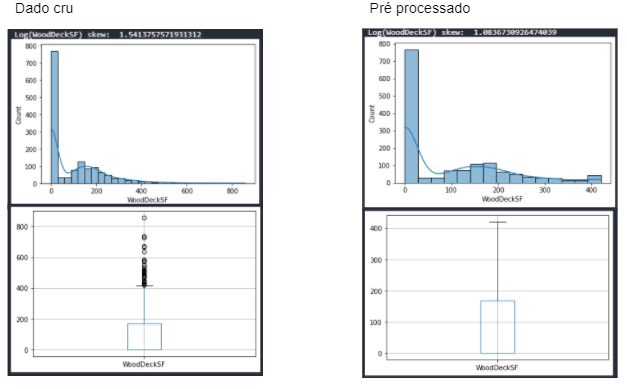

**LotArea**

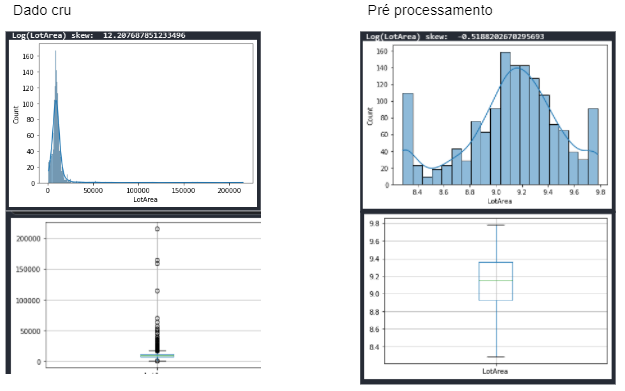

**GarageCars**

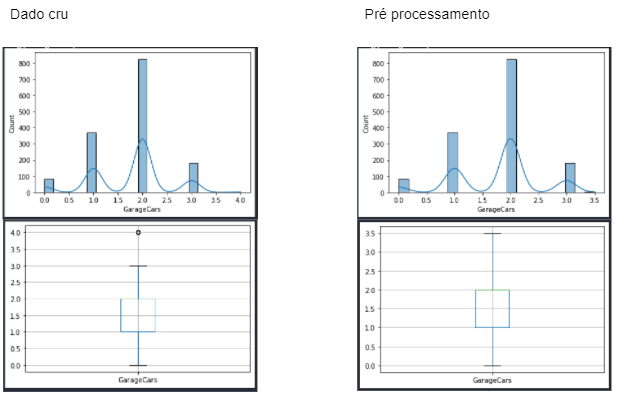

**TotalBsmtSF**

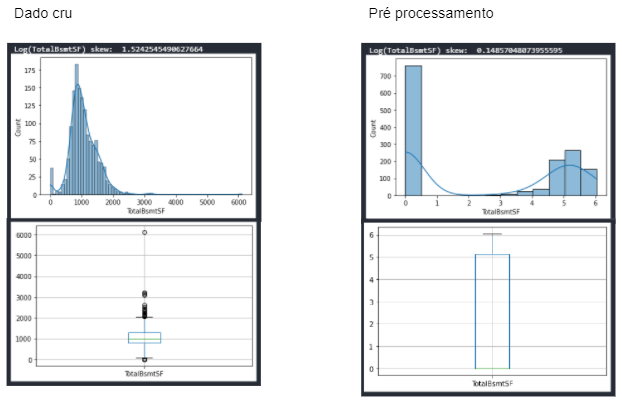

**2ndFlrSF**

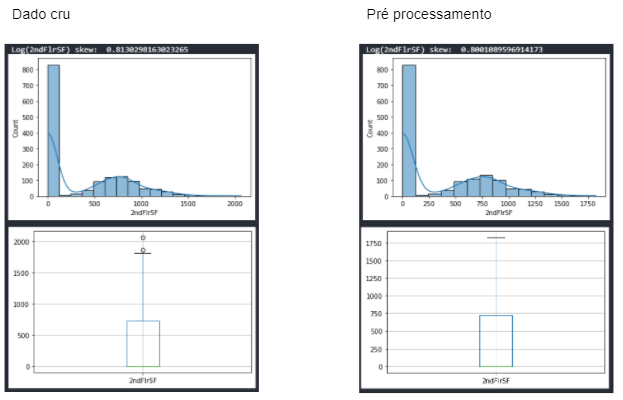

**1stFlrSF**

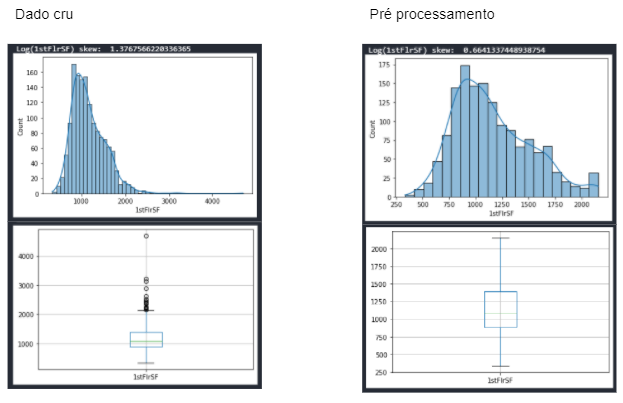

**LotFrontage**

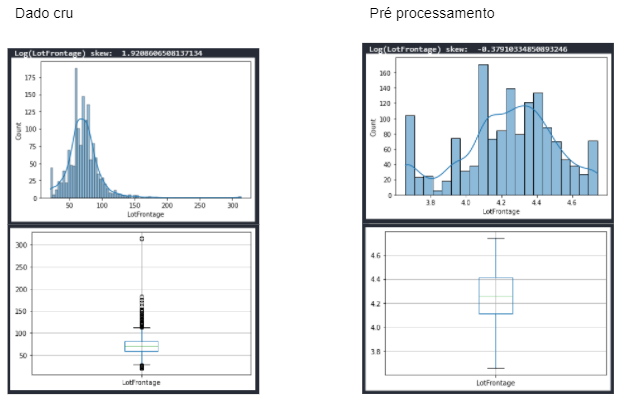

# Separação treino e teste

In [502]:

#Separação entre treino e teste
np.random.seed(50)
x_treino, x_teste, y_treino, y_teste = train_test_split (x, y, test_size = 0.20, random_state = 42)

# Testes em diferentes modelos
Na seção a seguir, fizemos diversos testes em diversos tipos de modelos. Inicialmente nós alteramos os parametros manualmente a cada execução e comparamos os resultados. Nesse momento, anotando resultados, percebemos que o Xgboost era extremamente melhor que o restante.

In [503]:
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

#modelo = DecisionTreeRegressor()
#modelo = naive_bayes.MultinomialNB(alpha=2,fit_prior=False)
#modelo = svm.SVR(C=2, kernel='linear', degree=3, gamma='auto')
#modelo=RandomForestRegressor(max_depth=6, random_state=0)
#modelo = MLPRegressor(random_state=1, max_iter=1000)
#modelo=LinearRegression()
modelo = xgb.XGBRegressor()

modelo_treinado=modelo.fit(x_treino, y_treino)

# Passamos os exemplos sem classe pelo modelo treinado, que retorna a predicao em um vetor
predicoes = modelo_treinado.predict(x_teste)

# Com as predicoes, podemos calcular as métricas. Abaixo, a acurácia.
# Observe que sempre passamos os valores verdadeiros (y_teste) e depois as predicoes
#acuracia = accuracy_score(y_teste, predicoes)
#print("Acurácia do modelo: ", acuracia)

score=modelo_treinado.score(x_teste,y_teste)
print(score)
from sklearn.metrics import explained_variance_score
print(explained_variance_score((y_teste), (predicoes)))
mean_squared_error ((y_teste), (predicoes))

# Função teste_columns

A função teste_columns remove coluna a coluna verificando o impacto dela no desempenho do modelo. Seguimos o passo: 

Remove coluna **->** verifica score **->** adiciona novamente **->** prossegue para proxima coluna

In [504]:
#vamos remover as colunas uma a uma e verificar qual impacta no desempenho
def teste_columns(ac,treino_x, treino_y,teste_x,teste_y):
    aux_collumns=[]
    aux_treino = treino_x
    aux_teste = teste_x
    for coluna in list(treino_x.columns):
        aux_treino = aux_treino.drop(coluna, axis='columns')
        aux_teste = aux_teste.drop(coluna, axis='columns')
        XGB = xgb.XGBRegressor()
        modelo_treinado=XGB.fit(aux_treino,y_treino)
        score=modelo_treinado.score(aux_teste,y_teste)
        
        aux_treino = treino_x
        aux_teste = teste_x
        if score>=ac:
            aux_collumns.append([score,coluna])
    return aux_collumns

#teste_columns(score,x_treino,y_treino,x_teste,y_teste)

# Escolha de parametros
A célula a seguir busca dentro de algumas opções, os melhores parametros para o nosso modelo

In [ ]:
xgb_reg = xgb.XGBRegressor()
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
param_grid = {
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    #'reg_lambda': [0,0.01, 0.1, 0.5, 1],
    #'reg_alpha': [0,0.01, 0.1, 0.5, 1],
    'colsample_bytree': [.3, .5],
    'learning_rate': [.07, .1, .3, ],
    'max_depth': [5, 6, 7],
    'n_estimators': [500, 5000],
    'subsample': [ 0.6, 0.7, 0.8],
}
model = GridSearchCV(estimator=xgb_reg,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_log_error',
                        cv=10)

model.fit(x_treino, y_treino)
cv_score = np.sqrt(-model.best_score_)

print('XGBoost RMSLE:', cv_score)

In [ ]:
from sklearn.metrics import mean_squared_log_error


preds = model.predict(x_teste)
real_msle = mean_squared_log_error(y_teste, preds)

final_score = np.sqrt(real_msle)

print(f' CV Score: {round(cv_score, 4)} '
    f' - Final Score: {round(final_score, 4)}')

# Modelo final 
As celulas a baixo são responsaveis pelo modelo final e gerar a submissão

Aqui, passamos por cada faze de pré-processamento para geração do modelo final com o melhor parametro encontrado.

In [ ]:


df_train=pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/train.csv",encoding='latin-1')
df_test=pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/test.csv",encoding='latin-1')

Y = df_train['SalePrice']

X = df_train.drop(['SalePrice','Id'],axis='columns')
X = label_encoding(X)

test = df_test.drop('Id',axis='columns')

test = label_encoding(test)


X = inputdata(X)
test = inputdata(test)



X = matematicsx(X)
test = matematicsx(test)

test=minimizarOutliders(X,test)
X = minimizarOutliders(X,X)


X = values_log(X)
test = values_log(test)

X = minimizarOutliders(X,X)
test = minimizarOutliders(X,test)


X = gerarCategoricos(X)
test = gerarCategoricos(test)

X =removerColunas(X)
test =removerColunas(test)



In [ ]:
import xgboost as xgb

xgb_best_params = model.best_params_

xgbr = xgb.XGBRegressor(**xgb_best_params)
xgbr = xgbr.fit(X, Y)

In [ ]:


predictions = xgbr.predict(test)


In [ ]:
Id = df_test['Id'] 
submit_df_1 = pd.DataFrame ({ 
                   "Id": Id, 
                  "SalePrice": predictions})

In [ ]:
submit_df_1.to_csv('submission_1_.csv', index = False)